In [2]:
import scanpy as sc
import pandas as pd
import infercnvpy as cnv
import numpy as np 

import sys
import os 
sys.path.append(os.path.expanduser(f"~/SSS_mount/insituCNV/InSituCNV"))
import insitucnv as icv

# CosMx CNV inference

## Read in dataset

In [2]:
sid = '221'

In [ ]:
adata = sc.read(os.path.expanduser(f"~/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/{sid}/adata_{sid}_processed_1.h5ad"))

In [9]:
# Subset to only contain the common genes across snPATHO-seq and CosMx for comparison
common_genes_df = pd.read_csv("snPATHO-seq/221_common_genes.csv")
common_genes_df.head()

adata = adata[:, adata.var_names.isin(common_genes_df['common_genes'])].copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 347023 × 14044
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'Dash', 'ISH.concentration', 'Panel', 'Run_Tissue_name', 'Run_name', 'assay_type', 'dualfiles', 'tissue', 'version', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_quantile_0.9', 'negprobes_quantile_0.95', 'negprobes_quantile_0.99', 'nCount_negprobes', 'nFeature_negprobes', 'median_falsecode', 'falsecode_quantile_0.75', 'falsecode_quantile_0.8', 'falsecode_quantil

In [11]:
adata.obs.add_sub.head()

c_2_1_2    epi
c_2_1_5    epi
c_2_1_7    epi
c_2_1_8    epi
c_2_1_9    epi
Name: add_sub, dtype: category
Categories (3, object): ['epi', 'imm', 'str']

## Run smoothing, CNV inference and epithelial clustering

In [12]:
# Compute the 200 nearest neighbors based on the PCA computation done in '1_prepare'
sc.pp.neighbors(adata, n_neighbors=200)

In [14]:
# Normalize the raw counts
adata.X = adata.layers['raw'].copy()
sc.pp.normalize_total(adata)

# Apply smoothing on 200 nearest neighbors
adata.layers['raw'] = adata.X.copy()
icv.tl.smooth_data_for_cnv(adata, n_neighbors=200)

# Normalize and log-transform the smoothed data
adata.X = adata.layers['M'].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Compute CNV inference using the REF region of interest as reference and with a window-size of 100
cnv.tl.infercnv(adata, 
                window_size =100,
                reference_key = 'ROI_status',
                reference_cat = ['REF'],
                chunksize = 1000)

  0%|          | 0/348 [00:00<?, ?it/s]

In [15]:
adata

AnnData object with n_obs × n_vars = 347023 × 14044
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'Dash', 'ISH.concentration', 'Panel', 'Run_Tissue_name', 'Run_name', 'assay_type', 'dualfiles', 'tissue', 'version', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_quantile_0.9', 'negprobes_quantile_0.95', 'negprobes_quantile_0.99', 'nCount_negprobes', 'nFeature_negprobes', 'median_falsecode', 'falsecode_quantile_0.75', 'falsecode_quantile_0.8', 'falsecode_quantil

leiden res 0.1
heatmap
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


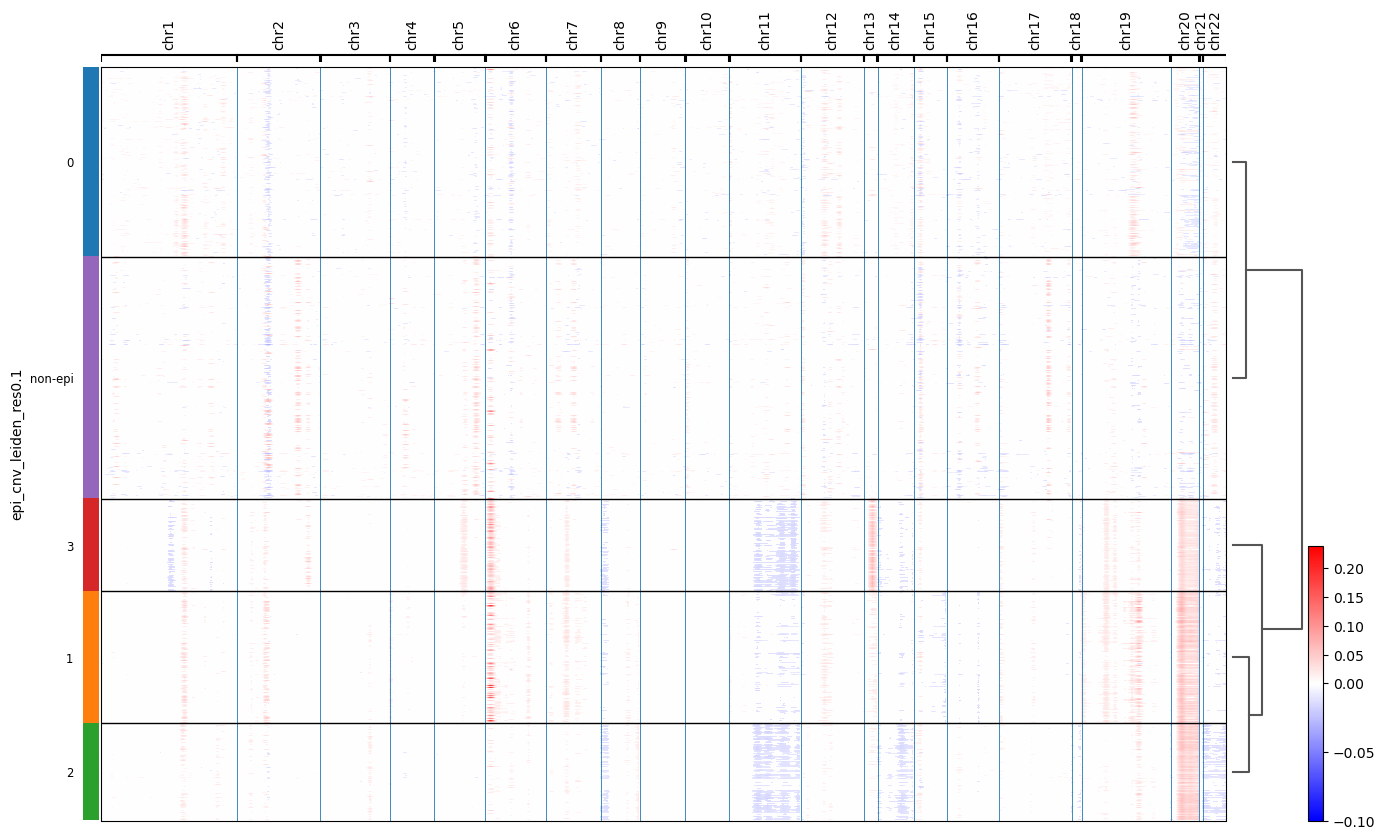

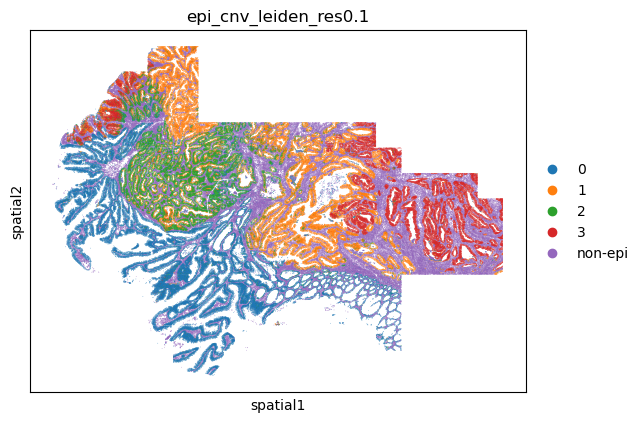

leiden res 0.2
heatmap
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


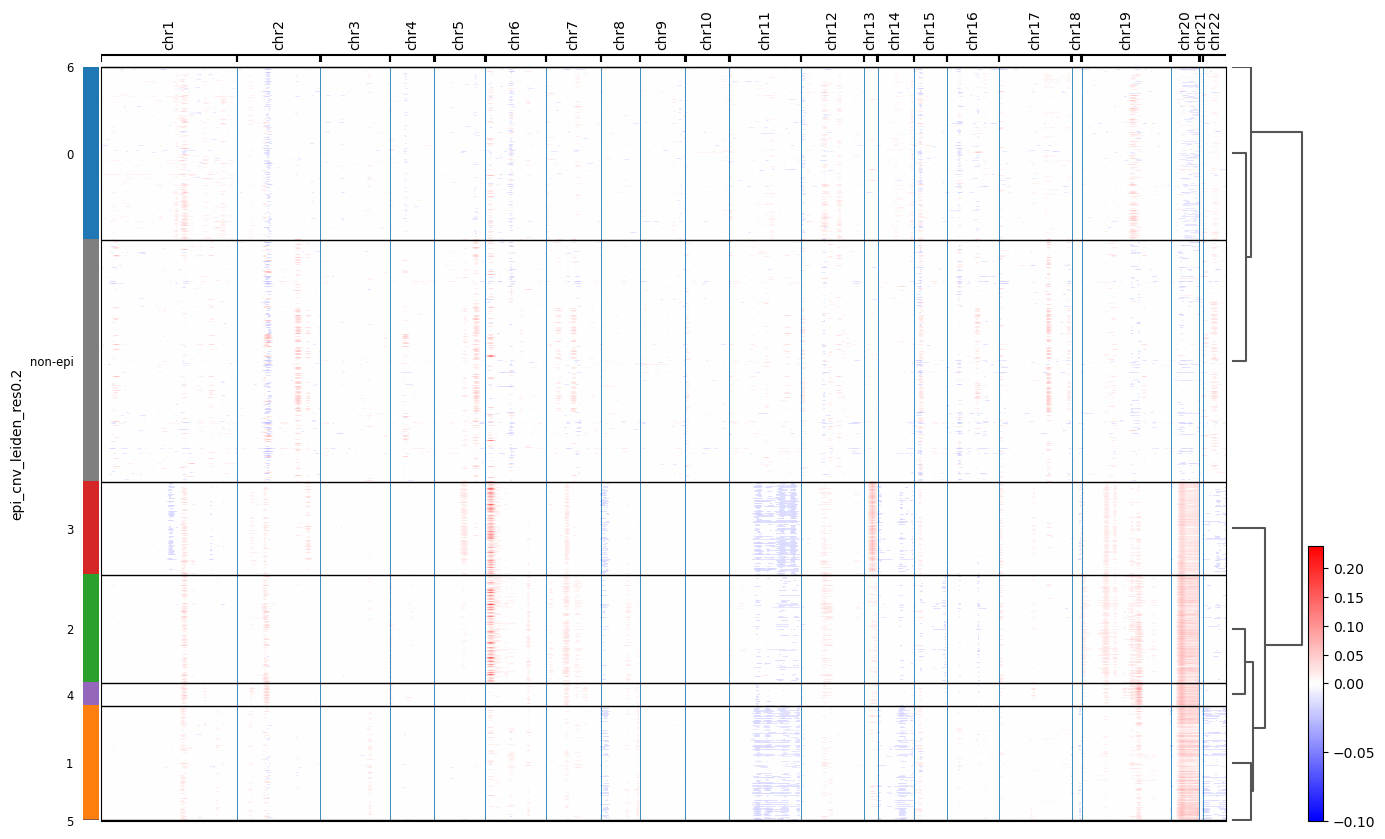

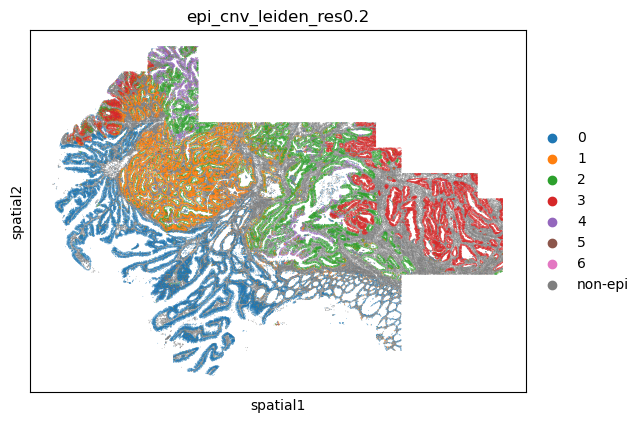

leiden res 0.3
heatmap
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


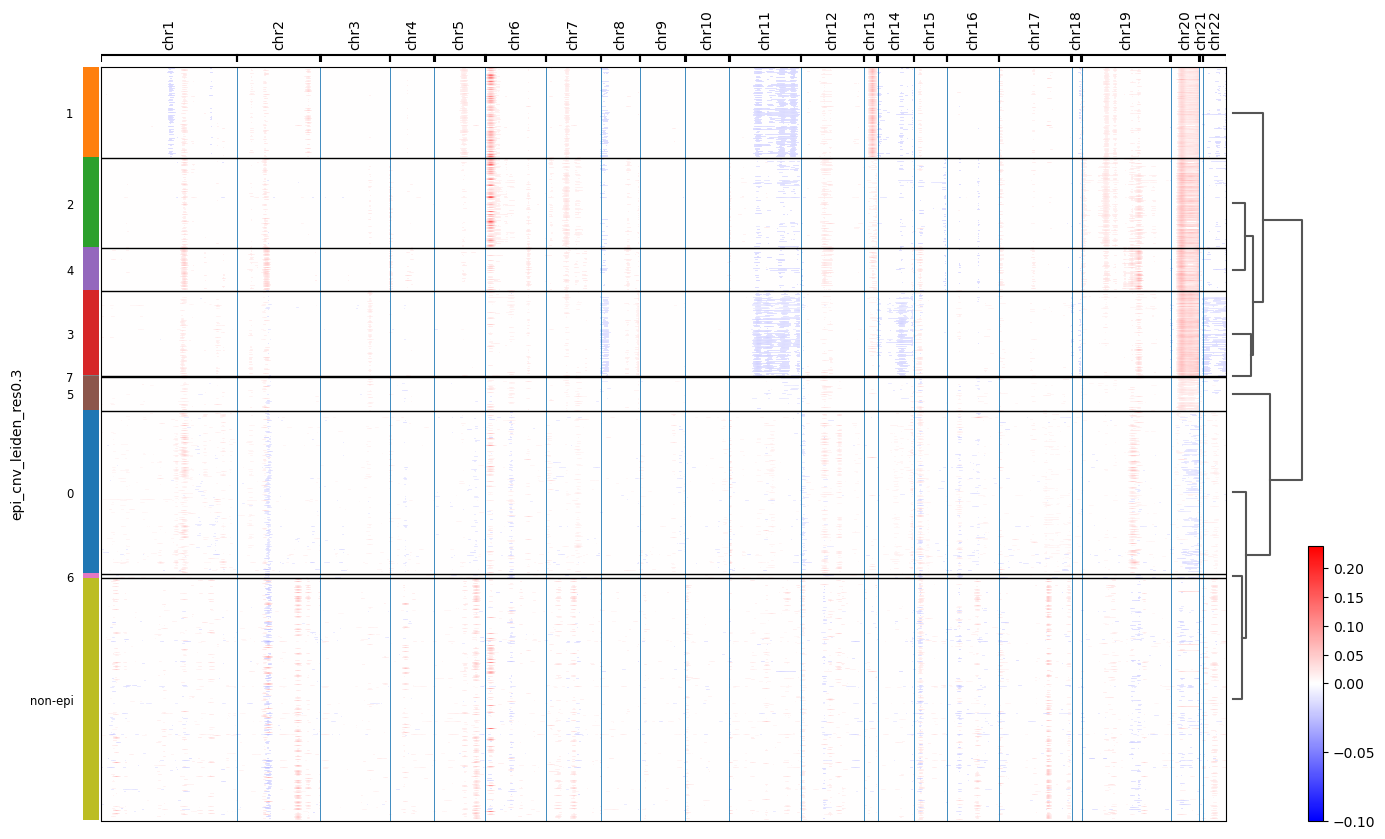

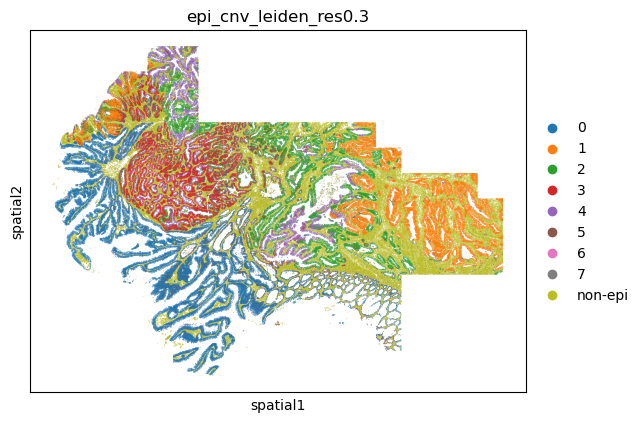

In [16]:
# Select only the epithelial cells and compute dimentionality reduction and nearest neighbor graph based on their CNV profiles
adata_epi = adata[adata.obs.add_sub == 'epi'].copy()
cnv.tl.pca(adata_epi)
cnv.pp.neighbors(adata_epi)

# Testing different resolutions
resolutions=[0.1, 0.2, 0.3]
    
for res in resolutions:

    # Cluster only the epithelial cells
    print('leiden res', res)
    key_added=f'epi_cnv_leiden_res{res}'
    cnv.tl.leiden(adata_epi, resolution = res, key_added=key_added)

    # Add the epithelial clustering back to the whole CosMx dataset
    adata.obs[key_added] = "non-epi"
    adata.obs.loc[adata_epi.obs_names, key_added] = adata_epi.obs[key_added]

    # Plot CNV heatmap with dentrogram and vmin and vmax for comparison.
    print('heatmap')
    save_heatmap = f"_CosMx_{sid}_common_n_200_groupby-{key_added}.pdf"
    cnv.pl.chromosome_heatmap(adata, groupby=key_added, dendrogram=True, save=save_heatmap, vmin=-.1) 

    sc.pl.spatial(adata, color=key_added, spot_size=100)

In [17]:
# For UMAP illustrations and CNV scores
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.umap(adata)

resolutions = [0.1, 0.2, 0.3]

for res in resolutions:
    groupby=f'epi_cnv_leiden_res{res}'
    key_added=f'epi_cnv_score_res{res}'
    cnv.tl.cnv_score(adata, groupby=groupby, key_added=key_added)

## Save new adata object with CNV information

In [21]:
adata.write(os.path.expanduser(f"~/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/{sid}/CosMx_{sid}_common_CNVinf.h5ad"), compression = 'gzip')

In [23]:
adata

AnnData object with n_obs × n_vars = 347023 × 14044
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'Dash', 'ISH.concentration', 'Panel', 'Run_Tissue_name', 'Run_name', 'assay_type', 'dualfiles', 'tissue', 'version', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_quantile_0.9', 'negprobes_quantile_0.95', 'negprobes_quantile_0.99', 'nCount_negprobes', 'nFeature_negprobes', 'median_falsecode', 'falsecode_quantile_0.75', 'falsecode_quantile_0.8', 'falsecode_quantil

## Plot and save heatmap figure

In [3]:
sid = '221'
adata=sc.read(os.path.expanduser(f"~/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/{sid}/CosMx_{sid}_common_CNVinf.h5ad"))

In [4]:
adata

AnnData object with n_obs × n_vars = 347023 × 14044
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'Dash', 'ISH.concentration', 'Panel', 'Run_Tissue_name', 'Run_name', 'assay_type', 'dualfiles', 'tissue', 'version', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_quantile_0.9', 'negprobes_quantile_0.95', 'negprobes_quantile_0.99', 'nCount_negprobes', 'nFeature_negprobes', 'median_falsecode', 'falsecode_quantile_0.75', 'falsecode_quantile_0.8', 'falsecode_quantil

In [5]:
adata.uns['epi_cnv_leiden_res0.1_colors']

array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
      dtype=object)

In [6]:
adata.uns['epi_cnv_leiden_res0.1_colors'] = ['#677DB7', #0
                                             '#FF773D', # 1
                                             '#FFCD4E',#2
                                             '#9B1D20',#3
                                             '#ada9b0',#non-epi
                                            ]

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


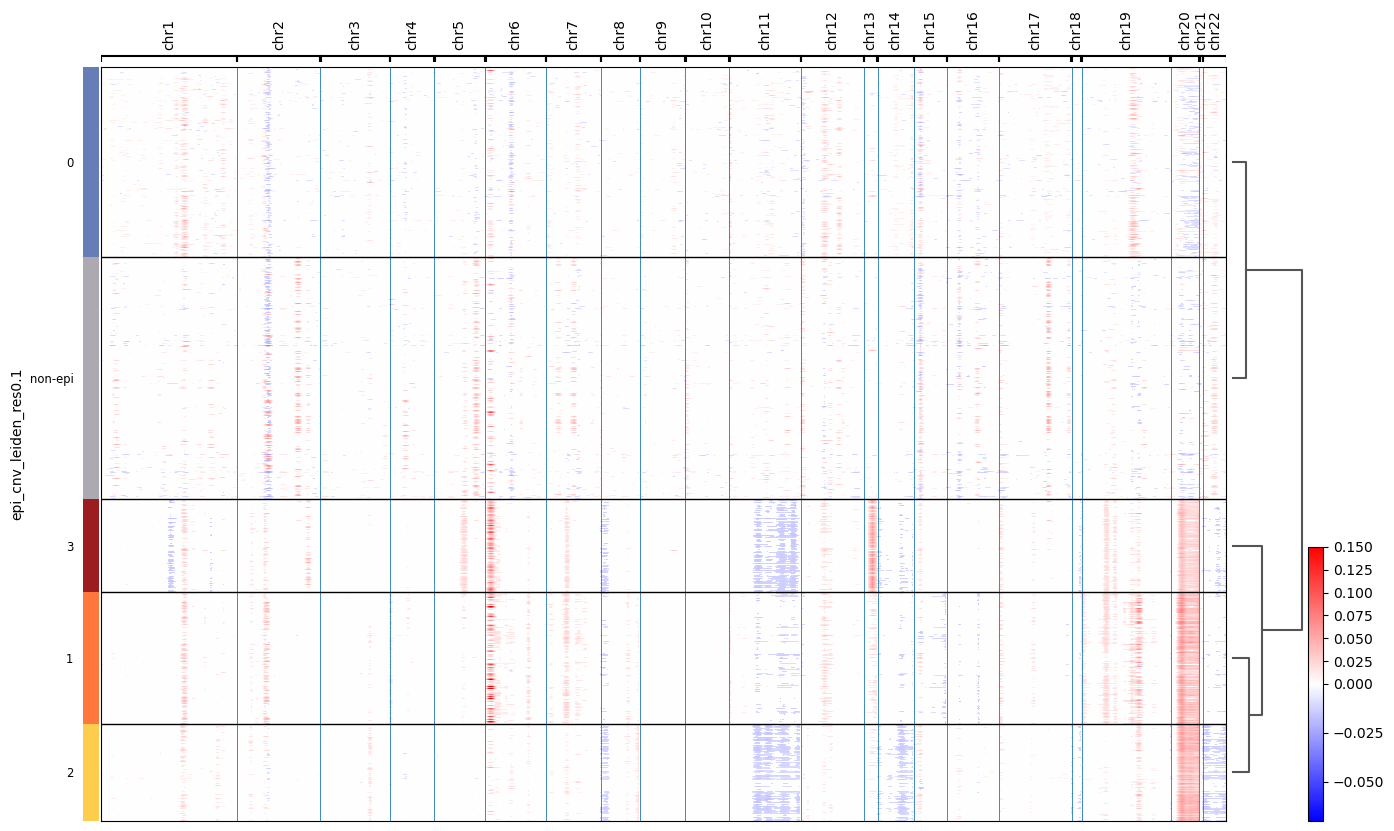

In [8]:
sid ='221'
groupby='epi_cnv_leiden_res0.1'
save_heatmap = f"_CosMx_{sid}_common_fig_groupby-{groupby}.pdf"
# save_heatmap = None
cnv.pl.chromosome_heatmap(adata, groupby=groupby, dendrogram=True, save=save_heatmap, vmin=-.07, vmax=0.15)